In [1]:
# import utilities and plotting
from sys import path
path.append('../lib')

from argparse import Namespace
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

%load_ext autoreload
%autoreload 2

# import our code that we need
import fixed_center_of_mass_exact as fcm
import fixed_center_of_mass_exact as fsm
from davidson import solve_davidson
from constants import *
from hamiltonian import solve_BO_surfaces

# don't use too many cores
from pyscf import lib as pyscflib
pyscflib.num_threads(16)

16

In [2]:
# set up the calculation
args = Namespace(
    M_1 = 10,
    M_2 = 50,
    g_1 = 1.0,
    g_2 = 1.0,
    NR = 101,
    Nr = 400,
    extent = np.array([2,3,0,2]),
)

# build the terms in the Hamiltonian
TR, Tr, Tmp, Vgrid, (R,P), (r,p) = fcm.build_terms(args)

# solve the BO surfaces
surfs = solve_BO_surfaces(Tr + Tmp, Vgrid)

Text(0.5, 1.0, 'Potential energy surface')

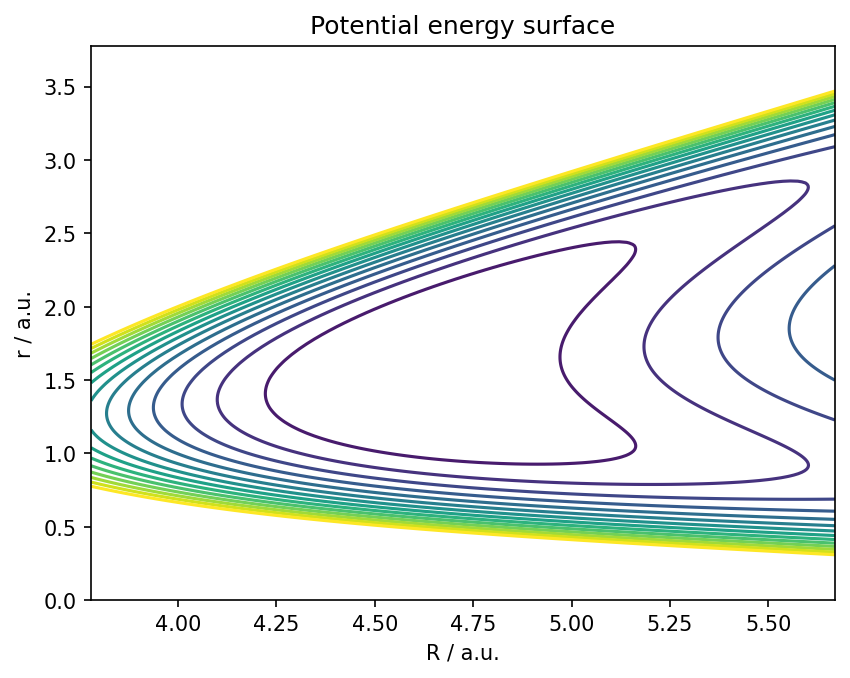

In [3]:
levels = np.linspace(np.min(Vgrid), 0.08, 15)
fig, ax = plt.subplots()
ax.contour(*np.meshgrid(R, r, indexing='ij'), Vgrid, levels=levels)
ax.set_xlabel("R / a.u.")
ax.set_ylabel("r / a.u.")
ax.set_title("Potential energy surface")

Text(0.5, 1.0, 'Born-Oppenhimer States')

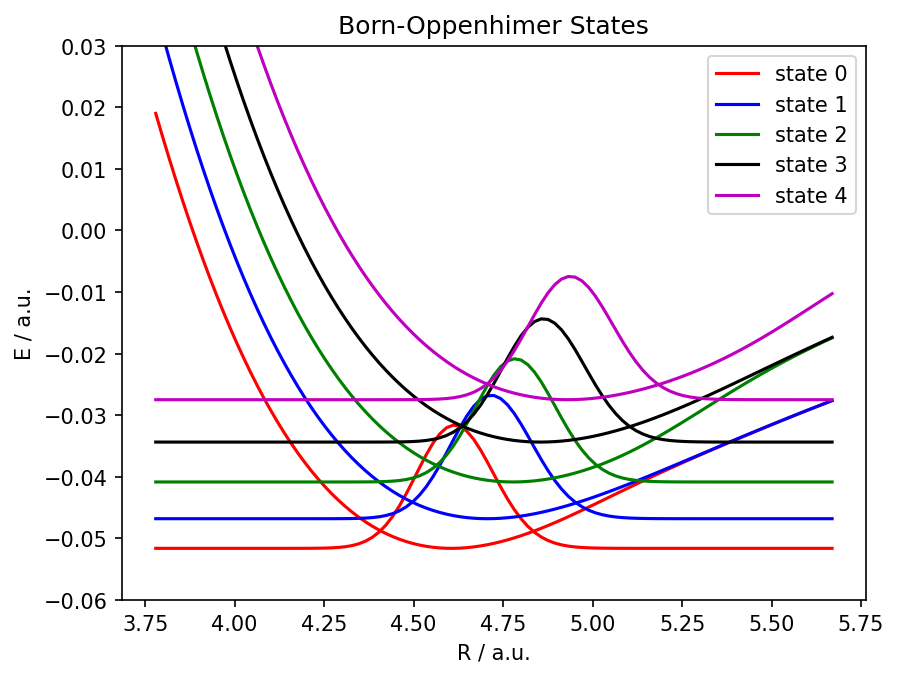

In [4]:
# plot the first 5 BO surfaces
fix, ax = plt.subplots()
colors=['r','b','g','k','m']
for i in range(5):
    ax.plot(R, surfs[i], color=colors[i])
    _, psi_bo = np.linalg.eigh(TR+np.diag(surfs[i]))
    psi_bo2 = psi_bo[:,0]**2
    ax.plot(R, psi_bo2/np.max(psi_bo2)*0.02+np.min(surfs[i]), color=colors[i], label=f'state {i}')
ax.legend(loc='best')
ax.set_xlabel("R / a.u.")
ax.set_ylabel("E / a.u.")
plt.ylim(-0.06,0.03)
ax.set_title("Born-Oppenhimer States")

Elapsed time: 4.206047281622887s


Text(0.5, 0.98, 'Trial wavefunctions')

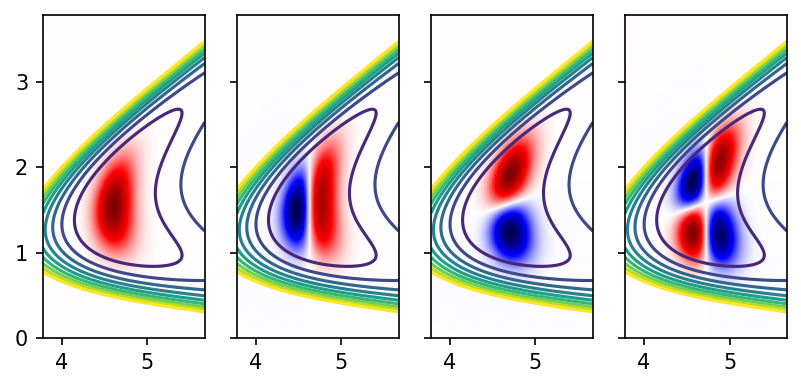

In [5]:
# plot the guesses
from davidson import build_preconditioner
_, guesses = build_preconditioner(TR, Tr+Tmp, Vgrid)
N=len(guesses)

levels = np.linspace(np.min(Vgrid), 0.08, 10)
fix, axs = plt.subplots(1,N, sharey=True)
for i, ax in enumerate(axs):
    ax.contour(*np.meshgrid(R, r, indexing='ij'), Vgrid, levels=levels)
    psi = guesses[i].reshape(args.NR,args.Nr)
    limit = np.max(np.abs(psi))
    ax.imshow(psi.T, extent=(args.extent * ANGSTROM_TO_BOHR), origin='lower', cmap='seismic', vmin=-limit, vmax=limit)
fig.suptitle("Trial wavefunctions")

In [6]:
# solve the full system (if this is the first time running, get rid of the guess)
conv, e_approx, evecs = solve_davidson(TR, Tr + Tmp, Vgrid, num_state=10)

Elapsed time: 4.165677711367607s
Davidson will consume up to 143912MB of memory.
Elapsed time: 8.06312906742096s


Text(0.5, 0.98, 'Solution wavefunctions')

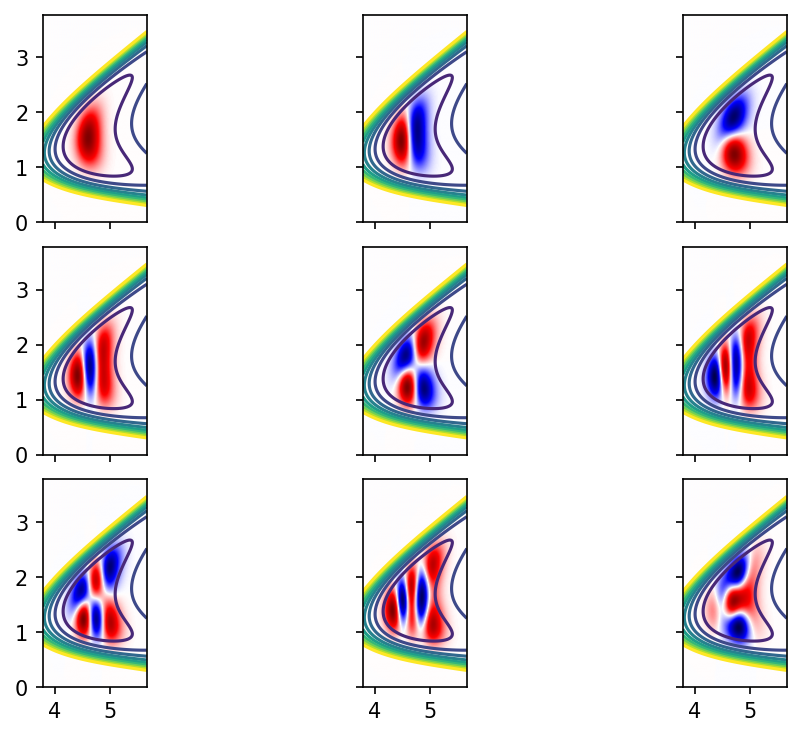

In [7]:
# plot the potential and the first excited wavefunction (with phase information)
levels = np.linspace(np.min(Vgrid), 0.08, 10)
fix, axs = plt.subplots(3,3, sharey='row', sharex='col', constrained_layout=True)
for i, ax in enumerate(axs.flatten()):
    ax.contour(*np.meshgrid(R, r, indexing='ij'), Vgrid, levels=levels)
    psi = evecs[i].reshape(args.NR,args.Nr)
    limit = np.max(np.abs(psi))
    ax.imshow(psi.T, extent=(args.extent * ANGSTROM_TO_BOHR), origin='lower', cmap='seismic', vmin=-limit, vmax=limit)
fig.suptitle("Solution wavefunctions")